In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import statistics
import scipy.stats
from sklearn.model_selection import train_test_split

In [2]:
# φόρτωση δεδομένων
ded=pd.read_excel('CogTEL_new.xlsx')

In [3]:
# μετατροπή αλφαριθμητικών σε float και παράλληλα μετατροπή "-" σε NaN
ded['education']=pd.to_numeric(ded['education'],errors='coerce')
ded['GDS_6']=pd.to_numeric(ded['GDS_6'],errors='coerce')
ded['GDS_8']=pd.to_numeric(ded['GDS_8'],errors='coerce')
ded['GDS_9']=pd.to_numeric(ded['GDS_9'],errors='coerce')
ded['NPIJ32F']=pd.to_numeric(ded['NPIJ32F'],errors='coerce')

In [4]:
# για να μπορώ να εξάγω τις συγκεκριμένες στήλες (αχρείαστο βήμα...)
ded = ded.rename(columns={'Antidepressants ': 'Antidepressants' })
ded = ded.rename(columns={'Concentration/attention' : 'Concentration_attention'})

In [5]:
# αφαίρεση στιγμιοτύπων με missing values
ded=ded.dropna()

In [6]:
# αφαίρεση των παραδειγμάτων ηλικίας 50 και κάτω
dedomena=ded[ded['Age']>49]

In [7]:
dedomena.shape

(504, 61)

In [8]:
# ανάθεση του συνόλου των ανεξάρτητων μεταβλητών και της μεταβλητής στόχου σε Χ και Υ
X=dedomena.drop('diagnosis',axis=1)
Y=dedomena.diagnosis

In [9]:
!pip install imblearn
!pip install imbalanced-learn

Class=0, n=208 (25.000%)
Class=2, n=208 (25.000%)
Class=1, n=208 (25.000%)
Class=3, n=208 (25.000%)


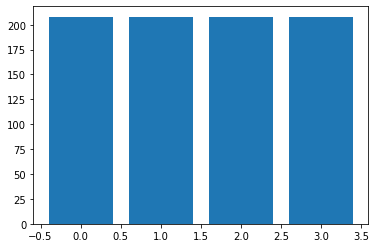

In [10]:
# τεχνική υπερδειγματοληψίας SMOTE 

from collections import Counter
from imblearn.over_sampling import SMOTE
oversample = SMOTE(random_state=7)
X, Y = oversample.fit_resample(X, Y)
# summarize distribution
counter = Counter(Y)
for k,v in counter.items():
    per = v / len(Y) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values())
plt.show()

In [11]:
# διαχωρισμός δεδομένων σε train και test set (μέθοδος hold-out)
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.3,random_state=3)

In [12]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
gb_clf2 = GradientBoostingClassifier(random_state=0)
gb_clf2.fit(X_train, Y_train)
predictions = gb_clf2.predict(X_test)
print("Classification Report")
print(classification_report(Y_test, predictions))

Classification Report
              precision    recall  f1-score   support

           0       0.90      0.81      0.85        69
           1       0.75      0.70      0.72        69
           2       0.93      0.85      0.89        66
           3       0.69      0.96      0.80        46

    accuracy                           0.82       250
   macro avg       0.82      0.83      0.82       250
weighted avg       0.83      0.82      0.82       250



In [13]:
# Κάνουμε nested CV 
# αργεί πολύ...
from sklearn.model_selection import GridSearchCV,cross_val_score,RepeatedKFold,KFold

clf1=GradientBoostingClassifier(random_state=67)
inner_cv = KFold(n_splits=3, shuffle=True, random_state=1)
outer_cv = KFold(n_splits=5, shuffle=True, random_state=1)
space=dict()
space['learning_rate']=[0.1, 0.5, 0.7, 1]
space['n_estimators']=[100, 200, 300, 400]
search = GridSearchCV(clf1, space, scoring='recall_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='recall_micro',cv=outer_cv, n_jobs=-1)
nested_scores

array([0.85628743, 0.79640719, 0.81325301, 0.80120482, 0.86746988])

In [14]:
search.best_params_

{'learning_rate': 0.7, 'n_estimators': 100}

In [15]:
nested_scores.mean()

0.8269244643243633

# OVO και OVR (ή OVA)

In [16]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import f1_score, recall_score, precision_score, accuracy_score

In [18]:
OvO_clf = OneVsOneClassifier(GradientBoostingClassifier(random_state=0))
OvO_clf.fit(X_train, Y_train)

y_pred = OvO_clf.predict(X_test)

print('Precision-micro of OvO Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvO Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvO Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvO Classifier: 0.81
Recall-micro of OvO Classifier: 0.81
f1-micro of OvO Classifier: 0.81


In [22]:
# nested cv για ΟVO
# αργεί πολύ (15')
# για τον συντονισμό των υπερπαραμέτρων με τους ταξινομητές OVO και OVR χρησιμοποιείται το πρόθεμα 'estimator__' για κάθε υπερπαράμετρο που ελέγχουμε
clf=OneVsOneClassifier(GradientBoostingClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space=dict()
space['estimator__n_estimators']=[100, 200, 300]
space['estimator__learning_rate']=[0.1, 0.5, 1]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores

array([0.88095238, 0.94047619, 0.8313253 , 0.79518072, 0.85542169,
       0.80722892, 0.89156627, 0.84337349, 0.89156627, 0.86746988])

In [23]:
nested_scores.mean()

0.8604561101549054

In [24]:
from sklearn.metrics import accuracy_score
OvR_clf = OneVsRestClassifier(GradientBoostingClassifier(random_state=0))
OvR_clf.fit(X_train, Y_train)

y_pred = OvR_clf.predict(X_test)

print('Precision-micro of OvR Classifier: {:.2f}'.format(precision_score(Y_test, y_pred, average='micro')))
print('Recall-micro of OvR Classifier: {:.2f}'.format(recall_score(Y_test, y_pred, average='micro')))
print('f1-micro of OvR Classifier: {:.2f}'.format(f1_score(Y_test, y_pred, average='micro')))

Precision-micro of OvR Classifier: 0.81
Recall-micro of OvR Classifier: 0.81
f1-micro of OvR Classifier: 0.81


In [25]:
# nested cv για ΟVR
# αργεί πολύ (15')
# για τον συντονισμό των υπερπαραμέτρων με τους ταξινομητές OVO και OVR χρησιμοποιείται το πρόθεμα 'estimator__' για κάθε υπερπαράμετρο που ελέγχουμε
clf=OneVsRestClassifier(GradientBoostingClassifier(random_state=6))
inner_cv = KFold(n_splits=5, shuffle= True, random_state=1)
outer_cv = KFold(n_splits=10, shuffle=True, random_state=1)
space=dict()
space['estimator__n_estimators']=[100, 200, 300]
space['estimator__learning_rate']=[0.1, 0.5, 1]
search = GridSearchCV(clf, space, scoring='f1_micro', n_jobs=-1, cv=inner_cv, refit=True)
search.fit(X, Y)

nested_scores=cross_val_score(search, X, Y, scoring='f1_micro', cv=outer_cv, n_jobs=-1,error_score="raise")
nested_scores

array([0.9047619 , 0.91666667, 0.84337349, 0.8313253 , 0.79518072,
       0.8313253 , 0.86746988, 0.79518072, 0.86746988, 0.89156627])

In [26]:
nested_scores.mean()

0.8544320137693632

In [27]:
search.best_estimator_

OneVsRestClassifier(estimator=GradientBoostingClassifier(learning_rate=0.5,
                                                         n_estimators=300,
                                                         random_state=6))